<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/Ornstein_Uhlenbeck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of Ornstein-Uhlenbeck process/equation in 1D

$$
dX = \alpha\ (\mu - X)\ dt + \sigma\ dW
$$
with $dW = \mathcal{N}(mean=0,std=\sqrt{dt})$ a brownian term.

In [ ]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

jax.config.update("jax_enable_x64", True)

# Numpy
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
mpl.rcParams['font.size'] = 18


from functools import partial

In [ ]:
#@partial(jit, static_argnums=(2,))
def update(rng_key, position, alpha, sigma, mu):
  key, subkey = jax.random.split(rng_key)
  move_proposals = jax.random.normal(key) * sigma
  proposal = mu + (1-alpha)*position + move_proposals
  return proposal


#@partial(jit, static_argnums=(1,2))
def sampler(rng_key, n_samples, alpha, sigma, mu, initial_position):

  def _update(i, state):
        key, positions, alpha, sigma, mu = state
        _, key = jax.random.split(key)
        new_position = update(key, positions[i-1], alpha, sigma, mu)
        positions=positions.at[i].set(new_position)
        return (key, positions, alpha, sigma, mu)

  # all positions structure should be set before lax.fori_loop
  all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call

  initial_state = (rng_key,all_positions, alpha, sigma, mu)
  _, all_positions, *_ = jax.lax.fori_loop(1, n_samples,
                                                 _update,
                                                 initial_state)
  return all_positions


run_mc= vmap(sampler, in_axes=(0, None, None, None, None, 1), out_axes=0)


You can play for instance with the parameters as for insatnce
$$
\begin{align}
dt &\in \{0.1, 4.0/n_{samples}\} \\
\alpha & \in \{0.15, 0.7 \} \\
\mu & \in \{1.0, 1.5 \} \\
\sigma & \in \{0.3, 0.06\}
\end{align}
$$



In [ ]:
n_chains = 5       # nomber of chains
n_dim = 1          # dimensionality
n_samples = 1000   # number of samples per chain


dt = 4.0/n_samples # 0.1
alpha_orig = 0.7 # 0.15  # friction: strength to pull towards the mean
sigma_orig = 0.06 # 0.3
mu_orig = 1.0 # 1.5
#


#update parameters once for all
#(must be adapted if one want  $\alpha,\mu$ time-dependant)
alpha = alpha_orig * dt
sigma = sigma_orig * jnp.sqrt(dt)
mu = mu_orig * alpha


rng_key = jax.random.PRNGKey(42)
rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))
all_positions = run_mc(rng_keys, n_samples, alpha, sigma, mu, initial_position)
all_positions = all_positions.squeeze()


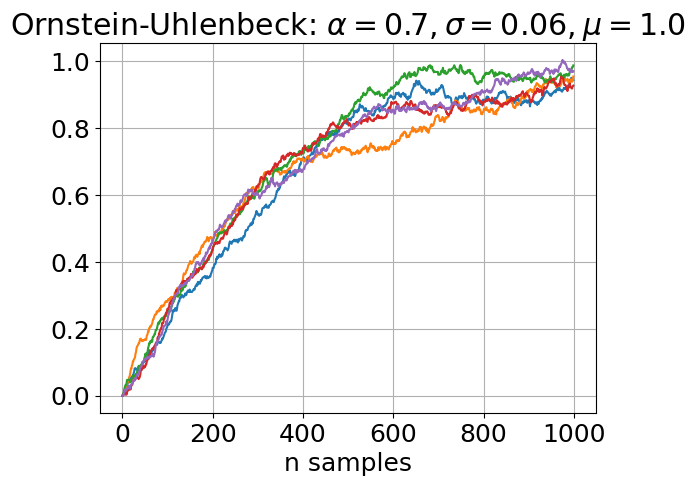

In [ ]:
plt.plot(all_positions.T);
plt.xlabel("n samples");
plt.title(fr"Ornstein-Uhlenbeck: $\alpha = {alpha_orig}, \sigma = {sigma_orig}, \mu = {mu_orig}$")
plt.grid()
